In [1]:
import sympy as sp
import numpy as np
from sympy.physics.vector import dynamicsymbols
from sympy.physics.vector import time_derivative
from sympy.physics.vector import ReferenceFrame
N = ReferenceFrame('N')
import pylab as pl
import control
from EoM import *
from sympy.physics.mechanics import *
from numpy.linalg import matrix_rank, eig
import math
import intelligent_robotics as ir
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
def rot_x(theta):
    rot_x = sp.Matrix([[1,0,0],
                       [0,sp.cos(theta),-sp.sin(theta)],
                       [0,sp.sin(theta),sp.cos(theta)]])
    return rot_x

def rot_y(theta):
    rot_y = sp.Matrix([[sp.cos(theta),0,sp.sin(theta)],
                       [0,1,0],
                       [-sp.sin(theta),0,sp.cos(theta)]])
    return rot_y

def rot_z(theta):
    rot_z = sp.Matrix([[sp.cos(theta),-sp.sin(theta),0],
                       [sp.sin(theta),sp.cos(theta),0],
                       [0,0,1]])
    return rot_z

def trans(a,b,c):
    x = sp.Matrix([[a],[b],[c]])
    return x

def get_torque_from_L(L,q,qd):
    round_L_round_q = sp.zeros(len(q),1);
    i = 0;
    for q_i in q:
        round_L_round_q_i = [];
        round_L_round_q_i = sp.diff(L,q_i);
        round_L_round_q[i] = round_L_round_q_i;
        i+=1;
     
    d_dt_round_L_round_qd = sp.zeros(len(qd),1);
    i = 0;
    for qd_i in qd:
        round_L_round_qd_i = [];
        d_dt_round_L_round_qd_i = [];
        round_L_round_qd_i = sp.diff(L,qd_i);
        d_dt_round_L_round_qd_i = time_derivative(round_L_round_qd_i,N);
        d_dt_round_L_round_qd[i] = d_dt_round_L_round_qd_i;
        i+=1;
        
    tau = d_dt_round_L_round_qd - round_L_round_q 
    return tau

In [3]:
r, L_1 = sp.symbols('r, L_1')
L_1c = sp.symbols('L_1c')
m_w, m_1, M, g = sp.symbols('m_w, m_1, M, g')
I_w, I_1 = sp.symbols('I_w, I_1')
theta_w, theta_1 = dynamicsymbols('theta_w, theta_1')

# Displacement Vector
x_c = trans(r*theta_w,0,0)
x_w = x_c +  trans(0,0,r)
x_1 = x_w +  rot_y(theta_1) @ trans(0,0,L_1c)
x = x_w +  rot_y(theta_1) @ trans(0,0,L_1)
# x_3 = x_w +  rot_y(theta_1) @ trans(0,0,L_1) + rot_y(theta_2) @ trans(0,0,L_2) + rot_y(theta_3) @ trans(0,0,L_3c) 
# x_4 = x_w +  rot_y(theta_1) @ trans(0,0,L_1) + rot_y(theta_2) @ trans(0,0,L_2) + rot_y(theta_3) @ trans(0,0,L_3) + rot_y(theta_4) @ trans(0,0,L_4c)



# Velocity Vector
v_w = sp.simplify(time_derivative(x_w,N))
v_1 = sp.simplify(time_derivative(x_1,N))
v = sp.simplify(time_derivative(x,N))
# v_3 = sp.simplify(time_derivative(x_3,N))
# v_4 = sp.simplify(time_derivative(x_4,N))


# Angular Velocity Vector
w_w = trans(0, theta_w.diff(), 0)
w_1 = trans(0, theta_1.diff(), 0)
# w_3 = trans(0, theta_3.diff(), 0)
# w_4 = trans(0, theta_4.diff(), 0)


# Generalized Coordinates
q = sp.Matrix([[theta_w], [theta_1]])
# q = sp.Matrix([[theta_w], [theta_1], [theta_2], [theta_3], [theta_4]])

qd = q.diff()
qdd = qd.diff()

# Kinetic Energy
T_trans = 0.5*(m_w*v_w.dot(v_w)  + m_1*v_1.dot(v_1) + M*v.dot(v) )
# T_trans = 0.5*(m_w*v_w.dot(v_w)  + m_1*v_1.dot(v_1) + m_2*v_2.dot(v_2) + m_3*v_3.dot(v_3) + m_4*v_4.dot(v_4))

T_wheel =I_w* w_w[1]**2 
T_1 =I_1* w_1[1]**2 
# T_3 =I_3* w_3[1]**2 
# T_4 = I_4* w_4[1]**2 
# T_rot = 0.5*(T_wheel + T_1 + T_2 + T_3 + T_4)
T_rot = 0.5*(T_wheel + T_1 )


# Potential Energy
V =  m_1*g*(L_1c*sp.cos(theta_1)) + M*g*(L_1*sp.cos(theta_1)) \
    # + m_3*g*(L_1*sp.cos(theta_1)+L_2*sp.cos(theta_2)+L_3c*sp.cos(theta_3)) \
    # + m_4*g*(L_1*sp.cos(theta_1)+L_2*sp.cos(theta_2)+L_3*sp.cos(theta_3)+L_4c*sp.cos(theta_4))    

# Lagrangian
L = T_trans + T_rot - V


In [4]:
T_trans + T_rot

0.5*I_1*Derivative(theta_1(t), t)**2 + 0.5*I_w*Derivative(theta_w(t), t)**2 + 0.5*M*(L_1**2*sin(theta_1(t))**2*Derivative(theta_1(t), t)**2 + (L_1*cos(theta_1(t))*Derivative(theta_1(t), t) + r*Derivative(theta_w(t), t))**2) + 0.5*m_1*(L_1c**2*sin(theta_1(t))**2*Derivative(theta_1(t), t)**2 + (L_1c*cos(theta_1(t))*Derivative(theta_1(t), t) + r*Derivative(theta_w(t), t))**2) + 0.5*m_w*r**2*Derivative(theta_w(t), t)**2

In [5]:
V

L_1*M*g*cos(theta_1(t)) + L_1c*g*m_1*cos(theta_1(t))

In [6]:
tau = get_torque_from_L(L,q,qd)
# tau = sp.simplify(tau)
# Ml, Cl, Gl, Wl = ir.get_EoM_from_T(tau,qdd,g)
# Ml, Cl, Gl, Wl

In [7]:
T_w, T_b= sp.symbols('T_w,T_b')
u = sp.Matrix([[T_w]])
# u = sp.Matrix([[T_w], [a], [T_2], [T_3], [T_4]])

u_matrix = sp.Matrix([[-T_w-T_b],[T_w-T_b]])
# u_matrix = sp.Matrix([[T_w],[a], [T_2], [T_3], [T_4]])

In [8]:
tau_eq = tau+u_matrix

In [9]:
tau_eq

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [10]:
M, C, G, W = get_EoM_from_T(tau_eq,qdd,g, u)

In [11]:
M

Matrix([
[1.0*I_w + 1.0*M*r**2 + 1.0*m_1*r**2 + 1.0*m_w*r**2, 1.0*r*(L_1*M + L_1c*m_1)*cos(theta_1(t))],
[          1.0*r*(L_1*M + L_1c*m_1)*cos(theta_1(t)),         1.0*I_1 + L_1**2*M + L_1c**2*m_1]])

In [12]:
C

Matrix([
[-1.0*L_1*M*r*sin(theta_1(t))*Derivative(theta_1(t), t)**2 - 1.0*L_1c*m_1*r*sin(theta_1(t))*Derivative(theta_1(t), t)**2 - 1.0*T_b],
[                                                                                                                             -T_b]])

In [13]:
G

Matrix([
[                                    0],
[-g*(L_1*M + L_1c*m_1)*sin(theta_1(t))]])

In [14]:
W

Matrix([
[ 1],
[-1]])

In [15]:
linearlize_eq = {sp.sin(theta_1):theta_1, sp.cos(theta_1):1, theta_1.diff()**2:0}
Ml = M.subs(linearlize_eq)
Cl = C.subs(linearlize_eq)
Gl = G.subs(linearlize_eq)
Wl = W.subs(linearlize_eq)
Ml

Matrix([
[1.0*I_w + 1.0*M*r**2 + 1.0*m_1*r**2 + 1.0*m_w*r**2,         1.0*r*(L_1*M + L_1c*m_1)],
[                          1.0*r*(L_1*M + L_1c*m_1), 1.0*I_1 + L_1**2*M + L_1c**2*m_1]])

In [18]:
param = {M: 20, T_b :10,I_1: 0.007514491, I_w:0.004806909,  m_1:2.786,   m_w:2.292, r:0.069,L_1c:0.15, L_1: 0.171,  g:9.81}

Mlp = msubs(Ml, param)
Clp = msubs(Cl, param)
Glp = msubs(Gl, param)
Wlp = msubs(Wl, param)
Mlp

Matrix([
[0.004761*M + 0.028983267,   0.011799*M + 0.0288351],
[  0.011799*M + 0.0288351, 0.029241*M + 0.070199491]])

In [19]:
param = {M: 20,T_b :10,I_1: 0.007514491, I_w:0.004806909,  m_1:2.786,   m_w:2.292, r:0.069,L_1c:0.15, L_1: 0.171,  g:9.81}

Mlp = msubs(Ml, param)
Clp = msubs(Cl, param)
Glp = msubs(Gl, param)
Wlp = msubs(Wl, param)

Mlp_inv = Mlp.inv()
qdd_rhs_A = Mlp_inv*(-Clp -Glp)
qdd_rhs_B = Mlp_inv*Wlp*u

X = q.col_join(qd)
Xd_A = qd.col_join(qdd_rhs_A)
Xd_B = qd.col_join(qdd_rhs_B)
U = u

A = Xd_A.jacobian(X)
B = Xd_B.jacobian(U)
C = X.jacobian(X)
D = X.jacobian(U)
A
# ss0 = [A, B, C, D]
# sys0 = control.ss(*[pl.array(mat_i.subs(param)).astype(float) for mat_i in ss0])
# mprint(sys0)

Matrix([
[0,                                                                                                                                                                                          0, 1, 0],
[0,                                                                                                                                                                                          0, 0, 1],
[0, (1.67751*M + 4.099599)*(5.6175039e-5*M**2 + 0.000479257478433*M + 0.0008357354022717)/(1.29047163580087e-22*M**3 - 2.38654074345968e-6*M**2 - 2.02565931063552e-5*M - 3.48711480995333e-5), 0, 0],
[0,                                                                  (-0.004761*M - 0.028983267)*(1.67751*M + 4.099599)/(2.71050543121376e-20*M**2 - 0.000501268797198*M - 0.0012031475989071), 0, 0]])

In [21]:
Q = sp.Matrix([ [1,0,0,0],
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1] ])
R = sp.Matrix([ [0.01,0],
             [0,0.01] ])

K, S, E = control.lqr(sys0.A, sys0.B, Q, R)


In [22]:
sysc = sys0.feedback(K)
sysc;

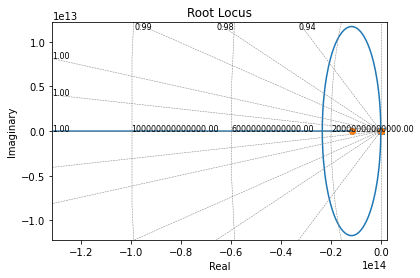

In [23]:
control.rlocus(sysc);

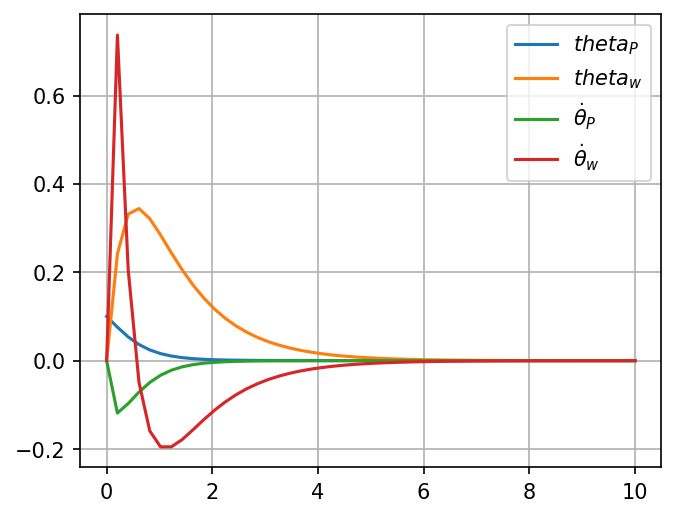

In [24]:
x0 = [0.1, 0, 0, 0]
u = 0
dt = 0.01
tf = 10

t, y = control.forced_response(sysc, X0=x0, T=pl.linspace(0,tf), transpose=True)

plt.figure(1, figsize=(5,4), dpi=150)
plt.plot(t, y);
plt.legend([r'$theta_P$',r'$theta_w$',r'$\dot\theta_P$',r'$\dot\theta_w$'], loc='best')
plt.grid()

In [25]:
# Rough 한 조건식
vmax_ = 5/3.6
t_ = 20# sec

target_pos = vmax_*t_
v = vmax_/target_pos
a = v/4
a

0.012499999999999999

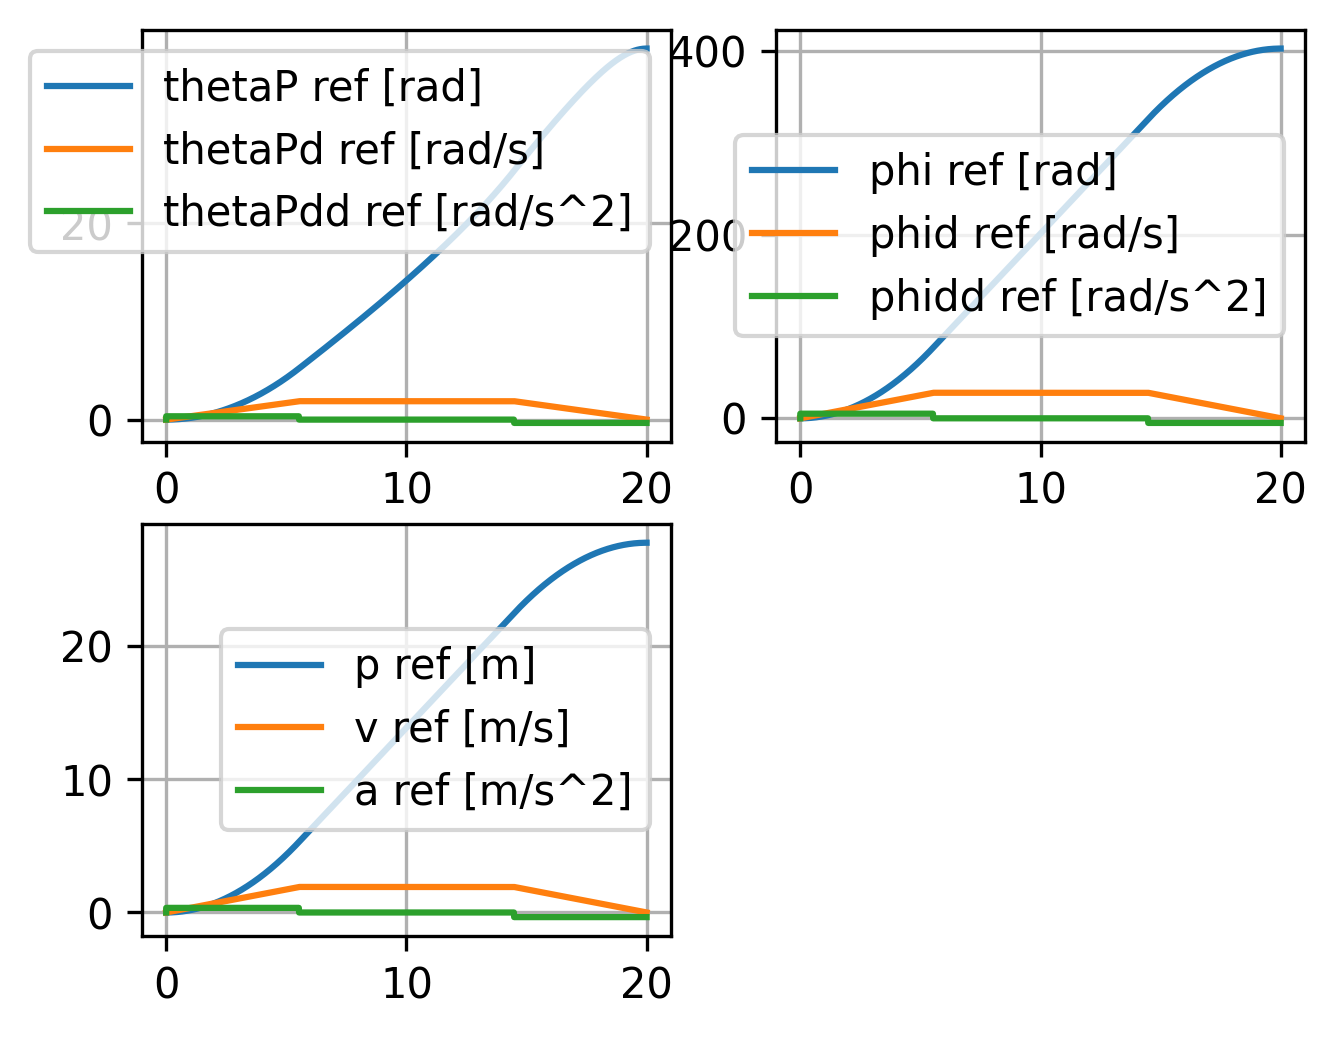

In [26]:
t_s, traj_s = ir.Trapezoidal_Traj_Gen_Given_Amax_and_T(a,t_,0.01)

l_t = 1.022142
thetaP_traj = np.arcsin(traj_s/l_t)
phi_traj = traj_s/ 0.069

rad2deg = 180/np.pi
pl.figure(1, figsize=(5,4), dpi=300)

pl.subplot(221);
pl.plot(t_s, thetaP_traj*target_pos);
pl.legend(['thetaP ref [rad]', 'thetaPd ref [rad/s]', 'thetaPdd ref [rad/s^2]'], loc='best');
pl.grid()

pl.subplot(222);
pl.plot(t_s, phi_traj*target_pos)
pl.legend(['phi ref [rad]', 'phid ref [rad/s]', 'phidd ref [rad/s^2]'], loc='best')
pl.grid()

pl.subplot(223);
pl.plot(t_s, traj_s*target_pos)
pl.legend(['p ref [m]', 'v ref [m/s]', 'a ref [m/s^2]'], loc='best')
pl.grid()

In [27]:
thetaP_traj[:,0]

array([0.00000000e+00, 0.00000000e+00, 6.11461030e-07, ...,
       1.36224628e+00, 1.36226105e+00, 1.36226991e+00])

In [28]:

thetaP_des = thetaP_traj[:,2]*target_pos
thetaw_des = phi_traj[:,0]*target_pos
thetawd_des = phi_traj[:,1]*target_pos
thetaPdot_des = thetaP_traj[:,1]*target_pos

zeros = np.zeros(len(thetaP_traj))
thetaPdes = thetaP_des
thetaPdes = np.vstack((thetaPdes, thetaw_des)) 
thetaPdes = np.vstack((thetaPdes, zeros))
thetaPdes = np.vstack((thetaPdes, thetawd_des))

thetaPdes.shape, thetaPdes

((4, 2001),
 array([[ 0.00000000e+00,  3.39709040e-01,  3.39709040e-01, ...,
         -3.39709040e-01, -3.39709040e-01, -3.39709040e-01],
        [ 0.00000000e+00,  0.00000000e+00,  2.51610306e-04, ...,
          4.02574225e+02,  4.02575483e+02,  4.02576238e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  5.03220612e-02, ...,
          1.50966184e-01,  1.00644122e-01,  5.03220612e-02]]))

In [29]:
thetaPdes

array([[ 0.00000000e+00,  3.39709040e-01,  3.39709040e-01, ...,
        -3.39709040e-01, -3.39709040e-01, -3.39709040e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.51610306e-04, ...,
         4.02574225e+02,  4.02575483e+02,  4.02576238e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.03220612e-02, ...,
         1.50966184e-01,  1.00644122e-01,  5.03220612e-02]])

In [30]:
thetaPdes[0:3,]

array([[ 0.00000000e+00,  3.39709040e-01,  3.39709040e-01, ...,
        -3.39709040e-01, -3.39709040e-01, -3.39709040e-01],
       [ 0.00000000e+00,  0.00000000e+00,  2.51610306e-04, ...,
         4.02574225e+02,  4.02575483e+02,  4.02576238e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [31]:
K[0][0:]

array([ 4.36537980e+02, -3.59770212e-01,  1.47118550e+02,  1.97061182e+00])

In [42]:
Q = sp.Matrix([ [1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1] ])
R = sp.Matrix([ [0.07,0],
                [0,0.07] ])

K, S, E = control.lqr(sys0.A, sys0.B, Q, R)
K

array([[355.42722115,   2.76634157, 119.16446354,   4.65659177],
       [ -8.31458362,   2.57547444,  -0.94461736,   2.57917216]])

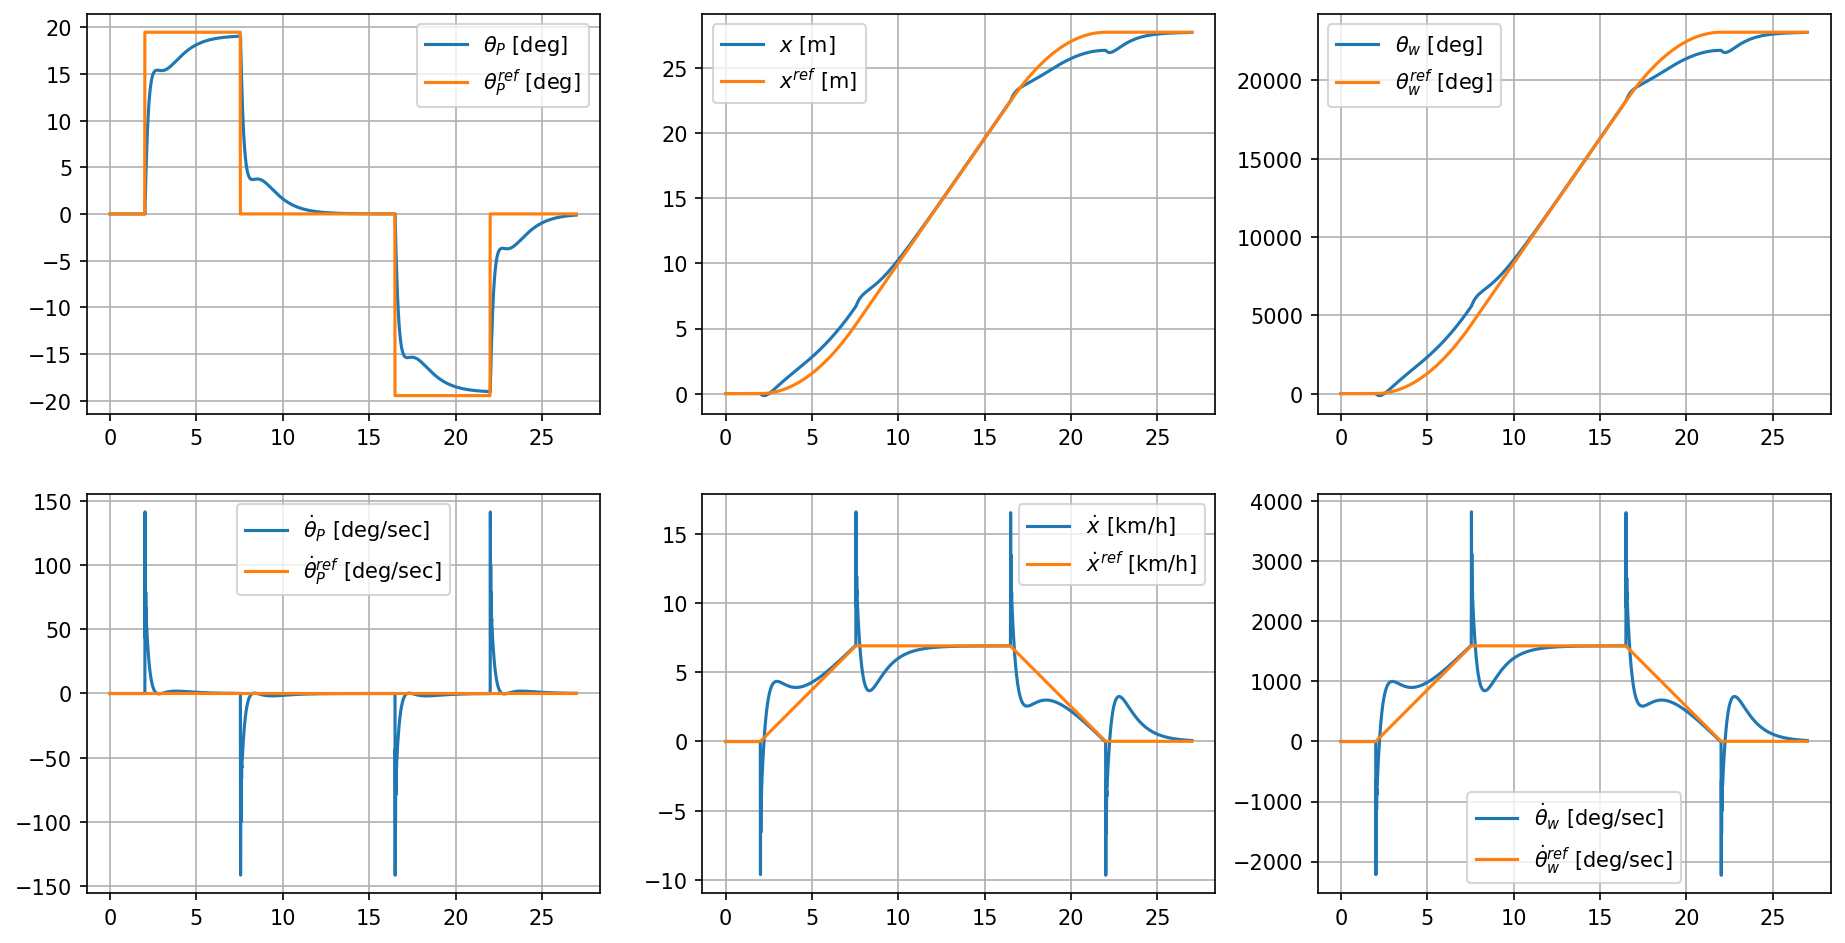

In [43]:
# Closed-loop Simulation
ss = sys0

rad2deg = 180/np.pi

def simulate_model_closed(X0, Xdes, K_gain, time_array, dt):
    Aop = ss.A
    Bop = ss.B
        
    t = 0
    j = 0
    X = Xref = Xd_prev = Xd = X0
    
    t_save = [0]
    x_save = xref_save = np.array([0,0,0,0])
    u_save = np.array([0,0])
    
    for i in range(len(time_array)):
        t = time_array[i]
         
        if t<2:
            Xref = X0       
        elif t>=2 and j<(Xdes.shape[1]):
            Xref = Xdes[:,j]
            j+=1
        else:
            Xdes_final = Xdes[:,Xdes.shape[1]-1]
            Xdes_final[0] = 0 # force to set xl_des as 0
            Xref = Xdes_final
        #print(t,j)
        # full-state feedback
        #u = K@(Xgoal - X)

        # partial feedback
        # u1 = K_gain[0][0:3,]@(Xref[0:3,] - X[0:3,])
        # u2 = K_gain[1][0:3,]@(Xref[0:3,] - X[0:3,])
        u1 = K_gain[0][0:]@(Xref[0:] - X[0:])
        u2 = K_gain[1][0:]@(Xref[0:] - X[0:])
        
        # Forward Dynamics
        #Xd_prev = Xd
        # Linear Model
        u = [u1, u2]
        Xd = Aop@X + Bop@u # Xd = [xd, x_ld, thetad, xdd, x_ldd, thetadd]
        # NonLinear Model
        #q_qd = {x:X[0], x_l:X[1], theta:X[2], x.diff():X[3], x_l.diff():X[4], theta.diff():X[5]}
        #q_qd[F] = u1
        #q_qd[F_l] = u2
        #qdd = msubs(qdd_rhs_A_nonL,q_qd) + msubs(qdd_rhs_B_nonL,q_qd)
        #Xd = np.array([X[3], X[4], X[5], float(qdd[0]), float(qdd[1]), float(qdd[2])])
        
        t_save = np.vstack((t_save, t))
        x_save = np.vstack((x_save, X))
        xref_save = np.vstack((xref_save, Xref))
        u_save = np.vstack((u_save, np.array([u1,u2])))
        
        X = X + Xd*dt        
        i+=1
       
        # #limit setting
        # xl_limit = 0.5
        # if  X[1] >= xl_limit:
        #     X[1] = xl_limit
        # elif X[1] <= -xl_limit:
        #     X[1] = -xl_limit
                 
    return t_save, x_save, xref_save, u_save

# initial condition
# [theta_P, theta_w, thetad_P, thetad_P]
X0 = np.array([0,0,0,0])

tf = 20 + 7
dt = 0.01
N = int(tf/dt)

# time points
t = np.linspace(0,tf,N)

# simulation
t_sim, x_sim, xref_sim, u_sim = simulate_model_closed(X0, thetaPdes, K, t, dt)

pl.figure(1, figsize=(15,12), dpi=150)

pl.subplot(331);
pl.plot(t_sim, x_sim[:,0]*rad2deg, t_sim, xref_sim[:,0]*rad2deg);
pl.legend([r'$\theta_P$ [deg]', r'$\theta_P^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(332);
pl.plot(t_sim, x_sim[:,1]*0.069, t_sim, xref_sim[:,1]*0.069);
pl.legend([r'$x$ [m]', r'$x^{ref}$ [m]'], loc='best')
pl.grid()

pl.subplot(333);
pl.plot(t_sim, x_sim[:,1]*rad2deg, t_sim, xref_sim[:,1]*rad2deg);
pl.legend([r'$\theta_w$ [deg]', r'$\theta_w^{ref}$ [deg]'], loc='best')
pl.grid()

pl.subplot(334);
pl.plot(t_sim, x_sim[:,2]*rad2deg, t_sim, xref_sim[:,2]*rad2deg);
pl.legend([r'$\dot\theta_P$ [deg/sec]', r'$\dot\theta_P^{ref}$ [deg/sec]'], loc='best')
pl.grid()

pl.subplot(335);
pl.plot(t_sim, x_sim[:,3]*0.069*3.6, t_sim, xref_sim[:,3]*0.069*3.6);
pl.legend([r'$\dotx$ [km/h]', r'$\dotx^{ref}$ [km/h]'], loc='best')
pl.grid()

pl.subplot(336);
pl.plot(t_sim, x_sim[:,3]*rad2deg, t_sim, xref_sim[:,3]*rad2deg);
pl.legend([r'$\dot\theta_w$ [deg/sec]', r'$\dot\theta_w^{ref}$ [deg/sec]'], loc='best')
pl.grid()

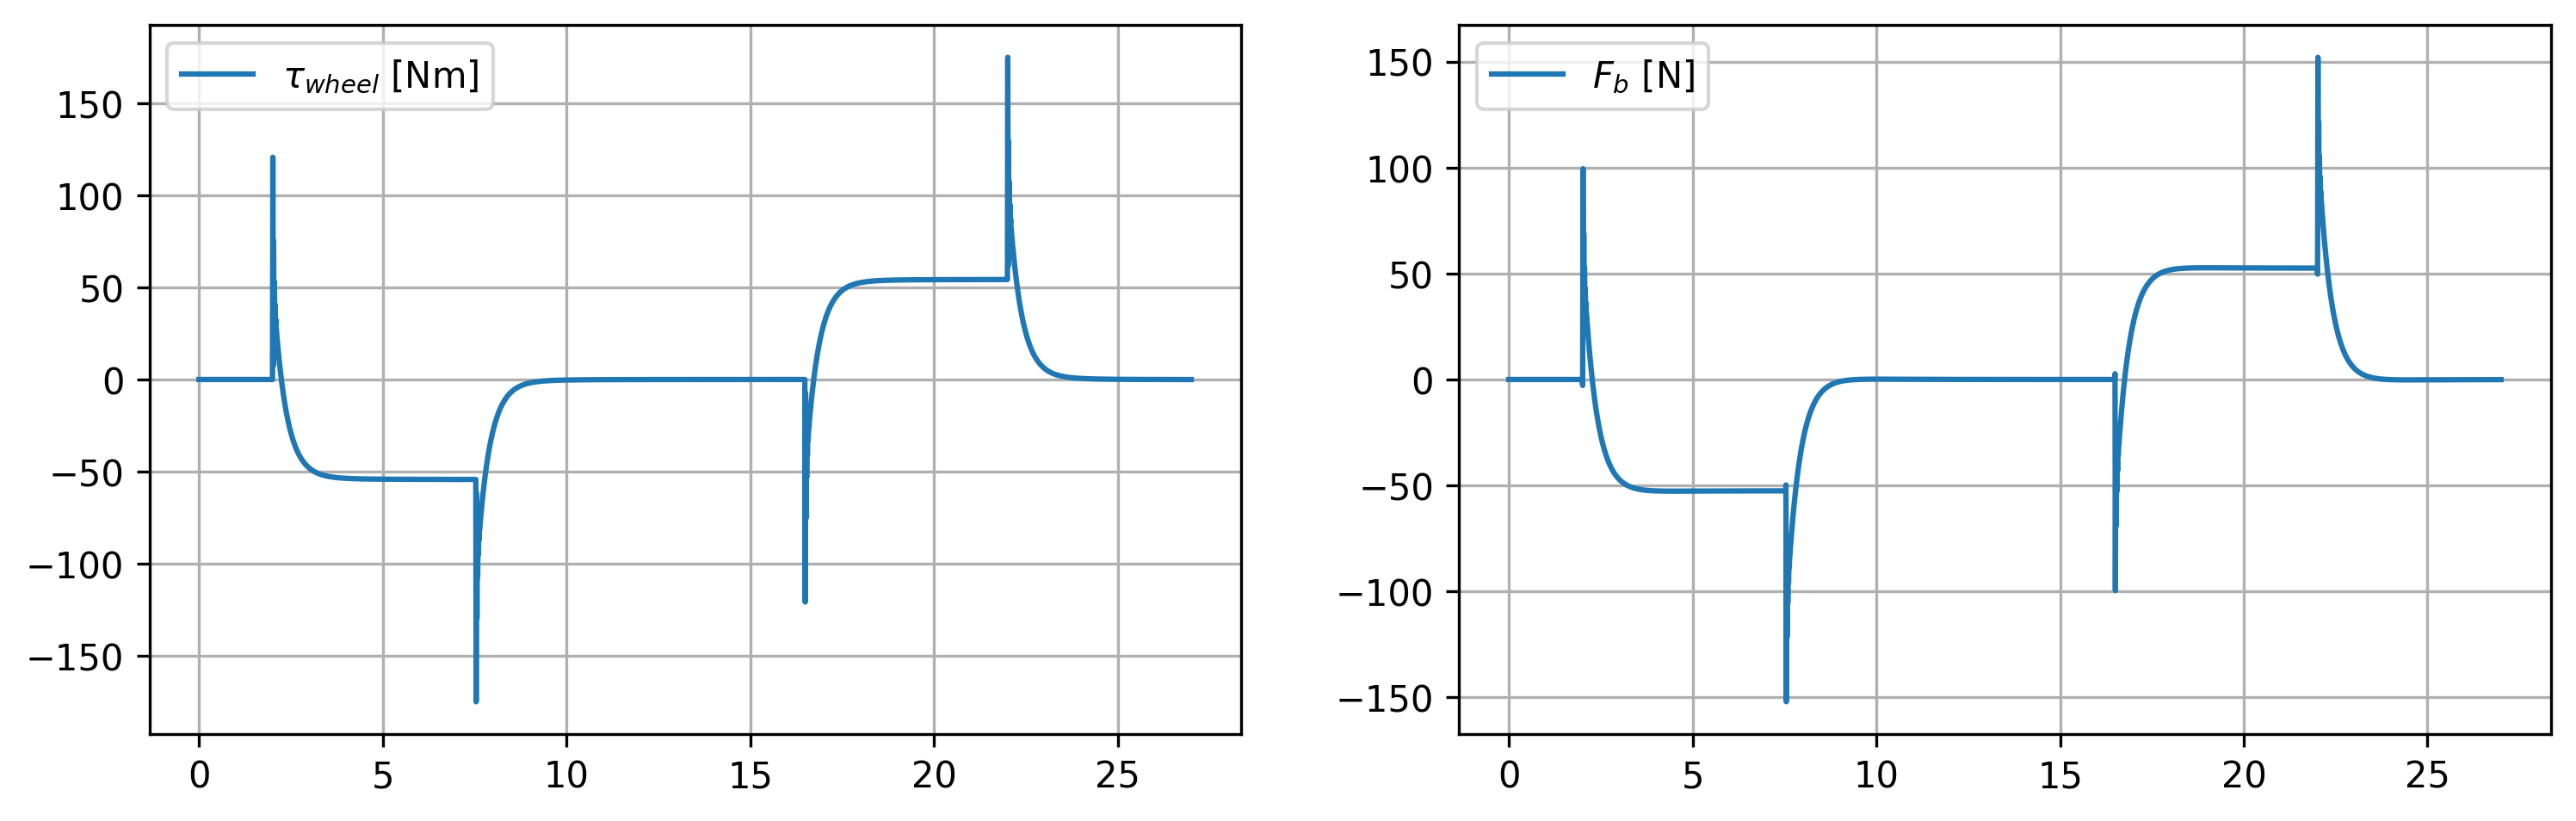

In [44]:
pl.figure(2, figsize=(12,8), dpi=300)


pl.subplot(221);
pl.plot(t_sim, u_sim[:,0]);
pl.legend([r'$\tau_{wheel}$ [Nm]'], loc='best')
pl.grid()

# pl.subplot(222);
# pl.plot(t_sim, u_sim[:,1]*0.8);
# pl.legend([r'$\tau_{body}$ [Nm]'], loc='best')
# pl.grid()

pl.subplot(222);
pl.plot(t_sim, u_sim[:,1]);
pl.legend([r'$F_b$ [N]'], loc='best')
pl.grid()

In [40]:
u_sim[:,0]

array([ 0.        ,  0.        ,  0.        , ..., -0.02173062,
       -0.02146986, -0.0212117 ])

In [39]:
u_sim[:,1]*1.02

array([ 0.        ,  0.        ,  0.        , ..., -0.06622263,
       -0.06620413, -0.06618579])

In [35]:
u_all = u_sim[:,0]+u_sim[:,1]*1.02
u_all


array([ 0.        ,  0.        ,  0.        , ..., -0.09324189,
       -0.09323475, -0.09322763])

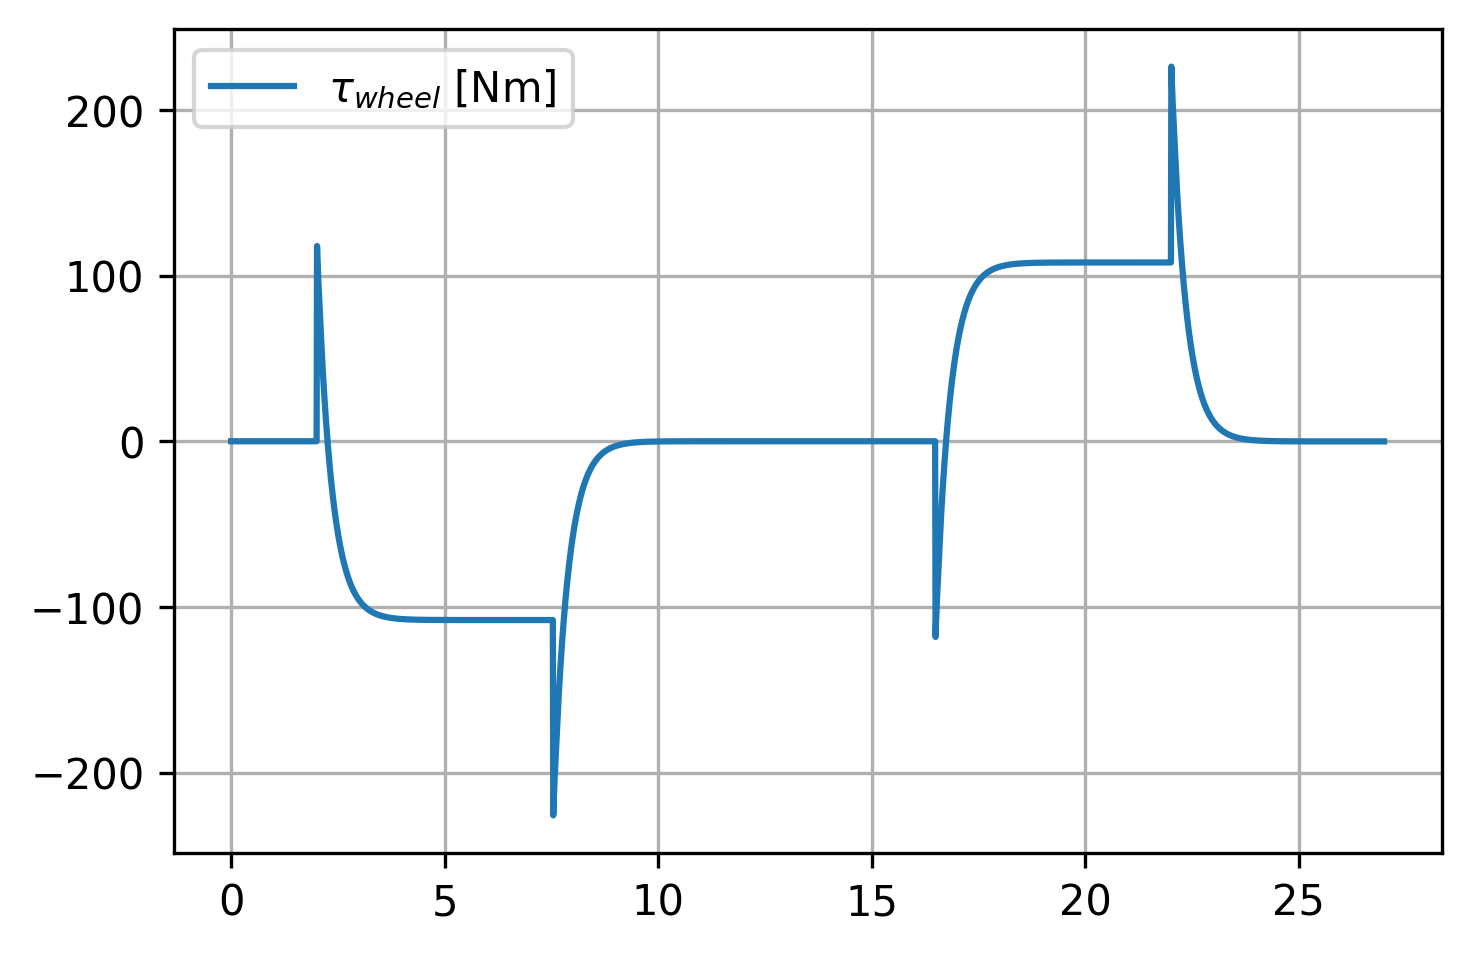

In [36]:
pl.figure(2, figsize=(12,8), dpi=300)


pl.subplot(221);
pl.plot(t_sim, u_all);
pl.legend([r'$\tau_{wheel}$ [Nm]'], loc='best')
pl.grid()

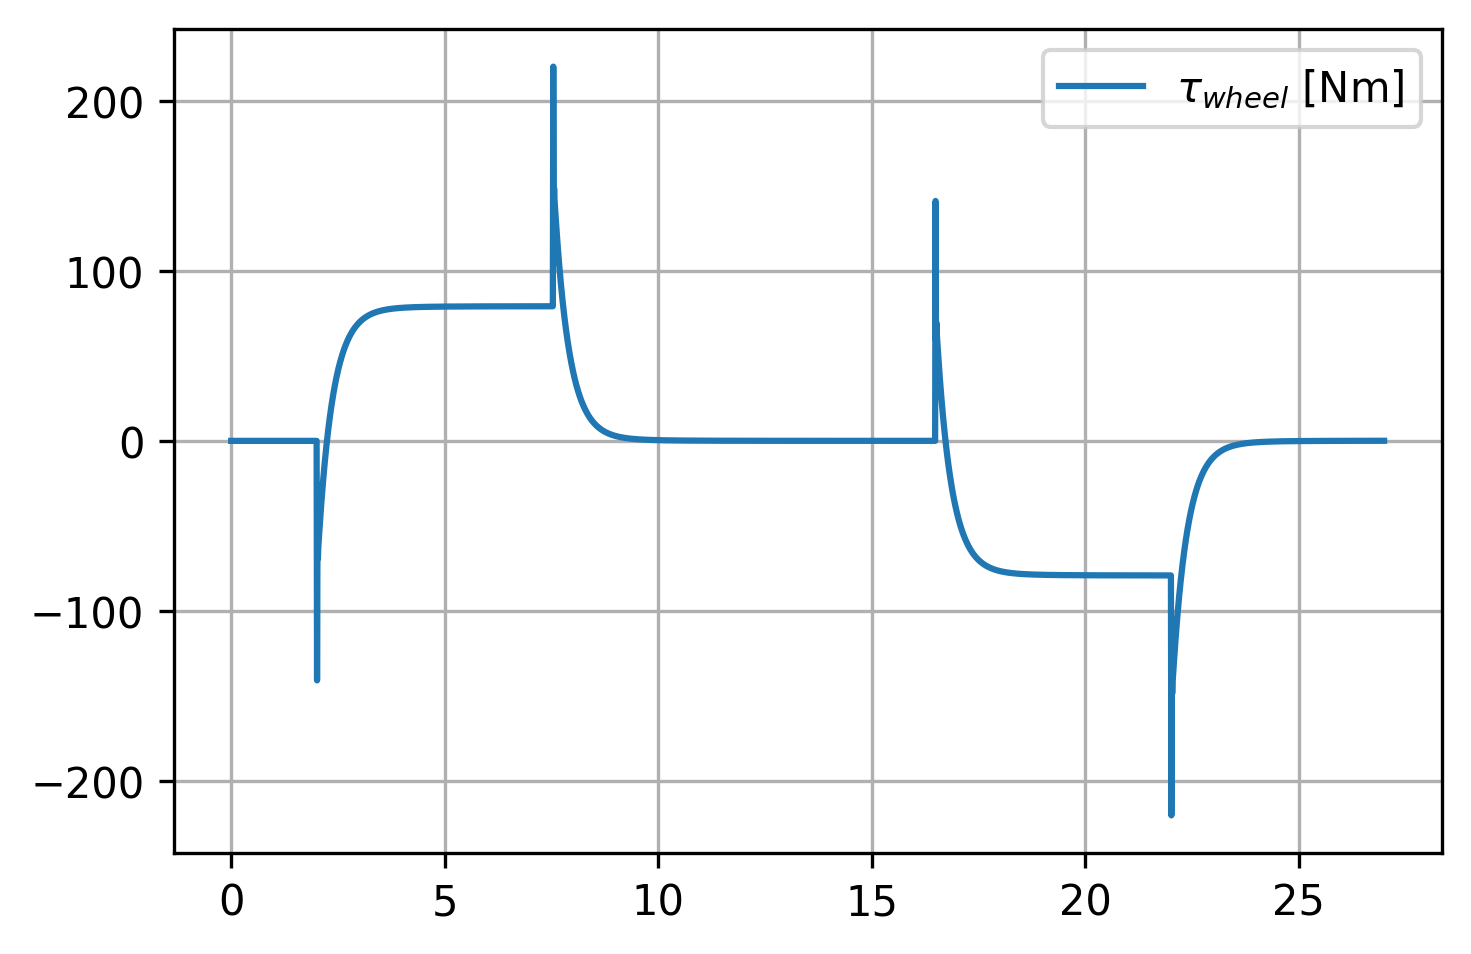

In [44]:
pl.figure(2, figsize=(12,8), dpi=300)


pl.subplot(221);
pl.plot(t_sim, u_all);
pl.legend([r'$\tau_{wheel}$ [Nm]'], loc='best')
pl.grid()

In [35]:
max(u_sim[:,0])

68.1114709118171

In [36]:
max(u_sim[:,1])

149.26751811017627